# 4th_hometask

In [1]:
import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_regression

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

# 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

### Исходный код из методички

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)
# classification_data, classification_labels = make_circles(n_samples=30, random_state=5)

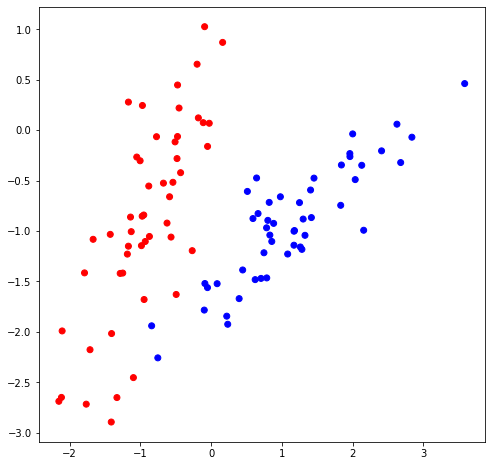

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
#     min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [15]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [16]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [17]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [19]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

In [20]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

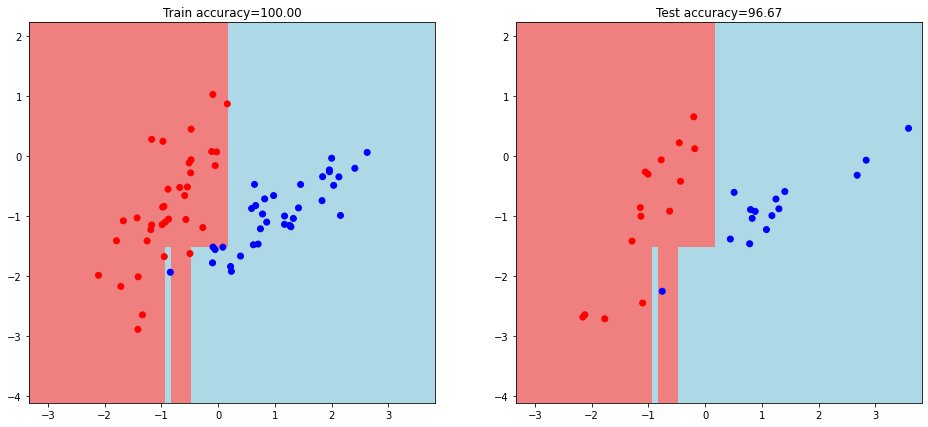

In [21]:
visualize(train_data, test_data)

In [22]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Индекс 0 <= -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0 <= -0.4942656820712277
      --> True:
        Индекс 0 <= -0.8411814419026544
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


### Критерий останова - количество листьев
Максимальное количество листьев опционально указывается при создании дерева с параметром "n_leafs". Каждому последующему ветвлению выделяется половина квоты листьев от вышестроящего ветвления. Данное разделение сделано с целью построения сбалансированных деревьев, чтоб каждая ветвь могла реализовать свой потенциал прироста информации в равной степени.

In [23]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, n_leafs=-1): # ==================== Изменения ====================

    gain, t, index = find_best_split(data, labels)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if (gain == 0) or (n_leafs == 1): # ==================== Изменения ====================
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, n_leafs // 2) # ==================== Изменения ====================

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels, n_leafs // 2) # ==================== Изменения ====================
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [24]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, n_leafs=4)

In [25]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [26]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [27]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [28]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

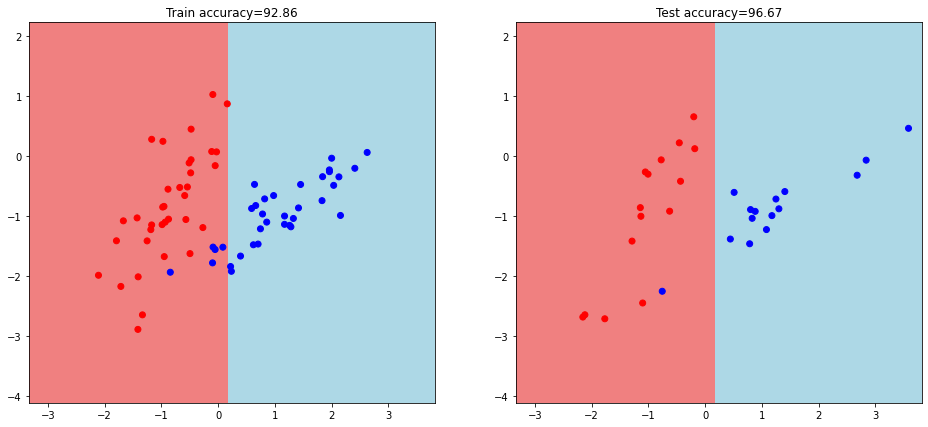

In [29]:
visualize(train_data, test_data)

In [30]:
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


### Критерий останова - количество используемых признаков

Максимальное количество используемых признаков опционально указывается при создании дерева с параметром "n_features". Параметр определяет сколько раз признаки могут использоваться для разбиения. Признаки могут повторяться, также количество использований признаков может быть больше количества признаков.

При создании нового узла дерева, который не является листом, параметр "n_features" уменьшается на единицу. Далее параметр "n_features" указывается для каждого последующего узла. При этом каждый последующий узел возращает параметр "n_features" в предыдущий узел. Таким образом, каждый узел дерева знает, сколько значений "n_features" потратили его дочерние узлы, и может остановить дальнейшую генерацию передав n_features=0 при построении дочерней ветви.

In [31]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch, n_features): # ==================== Изменения ====================
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
        self.n_features = n_features # ==================== Изменения ====================
#         self.n_features = n_features - isinstance(true_branch, Node) - isinstance(false_branch, Node)

In [32]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, n_features=-1): # ==================== Изменения ====================

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if (gain == 0) or (n_features == 0): # ==================== Изменения ====================
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    if n_features > 0: # ==================== Изменения ====================
        n_features -= 1 # ==================== Изменения ====================

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, n_features) # ==================== Изменения ====================

#     if (n_features > 0) and isinstance(true_branch, Node): # ==================== Изменения ====================
    if n_features > 0: # ==================== Изменения ====================
        n_features = true_branch.n_features # ==================== Изменения ====================
        if n_features < 0: # ==================== Изменения ====================
            n_features = 0 # ==================== Изменения ====================
    
#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels, n_features) # ==================== Изменения ====================
    
#     print(time.time(), false_branch)
    
    if (n_features > 0) and isinstance(false_branch, Node): # ==================== Изменения ====================
        n_features = false_branch.n_features # ==================== Изменения ====================
        if n_features < 0: # ==================== Изменения ====================
            n_features = 0 # ==================== Изменения ====================
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch, n_features)

In [33]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, n_features=2)

In [34]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [35]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [36]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [37]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

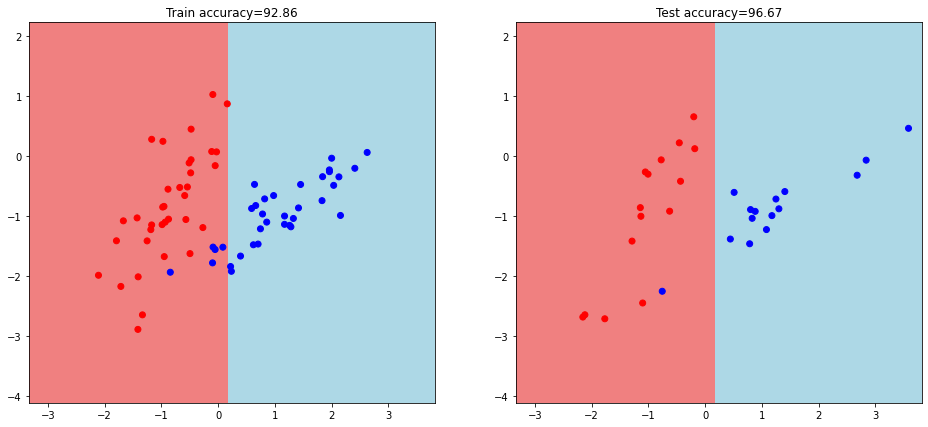

In [38]:
visualize(train_data, test_data)

In [39]:
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


### Критерий останова - глубина дерева

Максимальная глубина дерева опционально указывается при создании дерева с параметром "depth". При этом глубина уменьшается на единицу для каждого нового дочернего узла.

In [40]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [41]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, depth=-1):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if (gain == 0) or (depth == 0): # ==================== Изменения ====================
        return Leaf(data, labels)

    if depth > 0: # ==================== Изменения ====================
        depth -= 1 # ==================== Изменения ====================
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, depth) # ==================== Изменения ====================

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels, depth) # ==================== Изменения ====================
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [42]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, depth=1)

In [43]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [44]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [45]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [46]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

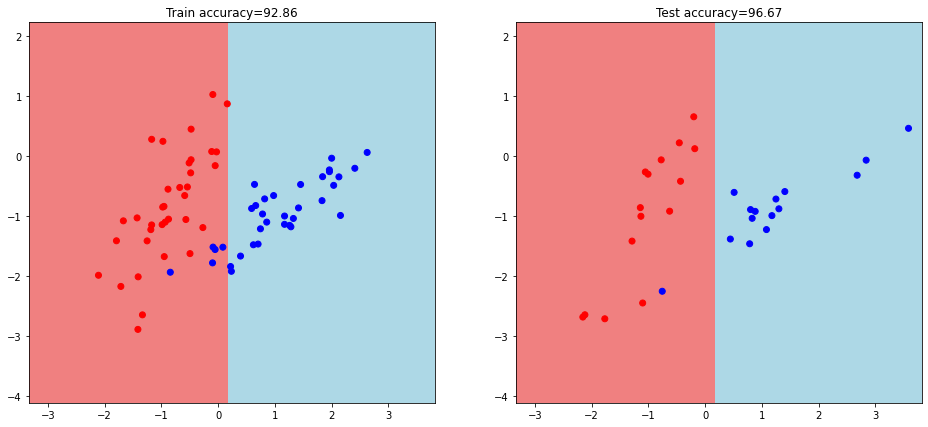

In [47]:
visualize(train_data, test_data)

In [48]:
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Прогноз: 0
--> False:
  Прогноз: 1


# 2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [49]:
# сгенерируем данные
X, y = make_regression(n_features=2, n_informative=2, n_targets=1, random_state=5) 
X.shape, y.shape

((100, 2), (100,))

In [50]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [51]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels) # ==================== Изменения ====================

In [52]:
# Расчет критерия Джини

def gini(labels):        
    return np.sum((labels - np.mean(labels))**2) # ==================== Изменения ====================

In [53]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [54]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [55]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 1 # ==================== Изменения ====================

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [56]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [57]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [58]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [59]:
# Разобьем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [60]:
# Построим дерево по обучающей выборке
my_tree = build_tree(X_train, y_train)

In [61]:
# Получим ответы для обучающей выборки 
train_answers = predict(X_train, my_tree)

In [62]:
# И получим ответы для тестовой выборки
answers = predict(X_test, my_tree)

In [63]:
# Точность на обучающей выборке
np.sqrt(mean_squared_error(y_train, train_answers))

0.0

In [64]:
# Точность на тестовой выборке
np.sqrt(mean_squared_error(y_test, answers))

17.54753310352028

##### Наблюдается переобучение.

In [65]:
print_tree(my_tree)

Индекс 0 <= -0.10061434630710828
--> True:
  Индекс 0 <= -0.689565232048181
  --> True:
    Индекс 0 <= -1.167278449710173
    --> True:
      Индекс 0 <= -2.2491181284434787
      --> True:
        Индекс 0 <= -2.386697744379377
        --> True:
          Прогноз: -152.49936131427688
        --> False:
          Прогноз: -149.66624361859945
      --> False:
        Индекс 1 <= -1.164701910115395
        --> True:
          Индекс 0 <= -1.3970740246682614
          --> True:
            Прогноз: -110.81020877241555
          --> False:
            Прогноз: -118.56057513568012
        --> False:
          Индекс 0 <= -1.4219245490984462
          --> True:
            Прогноз: -97.34193416486161
          --> False:
            Прогноз: -99.4655679805966
    --> False:
      Индекс 1 <= -0.3010051283841473
      --> True:
        Индекс 1 <= -0.9806078852186219
        --> True:
          Индекс 0 <= -0.7001790376899514
          --> True:
            Индекс 0 <= -0.8568531547160899
  